In [3]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
import importlib
import numpy as np
import copy
import spectral
import pickle
import os

import pandas as pd

import sys
sys.path.append('/workspaces/UPWINS_Microscene/')
import importlib

# local imports
#import hyperspectral_gta_data as hsi_data
from hsiViewer import hsi_viewer_layers as hvl
from hsiViewer import hsi_viewer_ROI as hvr
from hsiViewer import hsi_viewer as hsv
import microscene_functions as msf



# set the directory where data will be downloaded and accessed
# (This directory will be saved in a config file and used each time you use hyperspectral_gta_data, 
# so you don't need to run the 'set_data_dir' function every time you use hyperspectral_gta_data.)
#hsi_data.set_data_dir('C:/spectral_data')

# Part 1: Open the image and load the data as a numpy array.

## NOTE: This assumes that you have the filename for the hyperspectral image along with the ROI .pkl file.

In [ ]:
# filename for the image
#fname = 'C:/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref'
#fname_hdr = 'C:/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref.hdr'
# ROI file fname
#fname_roi = 'C:\\spectral_data\\spectral_images\\UPWINS Baccharis Halimifolia.pkl'

In [6]:
# filename for the image
fname = '/workspaces/UPWINS_Microscene/data/100104_Allied_3_7_2025_2015_06_04_18_33_04/raw_0_ref'
fname_hdr = '/workspaces/UPWINS_Microscene/data/100104_Allied_3_7_2025_2015_06_04_18_33_04/raw_0_ref.hdr'
# ROI file fname
#fname_roi = 'data/pkl/ROIs.pkl'

In [7]:
# Open the image and read into an array
im = spectral.envi.open(fname_hdr, fname)
wl_im = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
print(f'Shape of Im.Arr = {im.Arr.shape}')
im.List = np.reshape(im.Arr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of im.List = {im.List.shape}')
dataList = im.List[np.sum(im.List, axis=1)>0, :]
print(f'Shape of dataList = {dataList.shape}')
nr = im.nrows
nc = im.ncols
nb = im.nbands

Shape of Im.Arr = (1998, 505, 272)
Shape of im.List = (1008990, 272)
Shape of dataList = (1008990, 272)


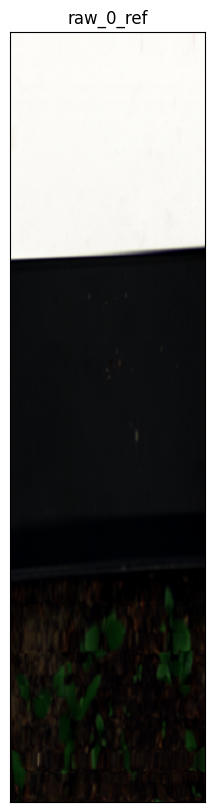

In [8]:
# Plot an RGB image of the hyperspectral image
# make the RGB image from the hyperspectral image (select RGB bands and applying stretch)
RGB_image = msf.make_rgb(im.Arr, wl_im, stretch = [2,98])
# Plot the image
plt.figure(figsize=(10,10))
plt.imshow(RGB_image)
plt.xticks([])
plt.yticks([])
plt.title(os.path.basename(fname));

# Download Spectral Library

In [9]:
import from_Jim.util_scripts as util
import os
from dotenv import load_dotenv

from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

_ = load_dotenv()

MONGO_DBR_URI = os.getenv('MONGO_DBR_URI')

In [10]:
reload_data_driver = False

if (reload_data_driver):

    records = []

    # Create a new client and connect to the server
    client = MongoClient(MONGO_DBR_URI, server_api=ServerApi('1'))

    # Send a ping to confirm a successful connection
    try:
        client.admin.command('ping')
        print("Pinged your deployment. You successfully connected to MongoDB!")
    except Exception as e:
        print(e)

    db = client["upwins_db"]
    view_name = "spectral_library"
    spectral_library = db[view_name]

    records = spectral_library.find()

    df = pd.DataFrame(records)
    df.to_pickle('/workspaces/UPWINS_Microscene/data/pkl/library.pkl')

else:
    df = pd.read_pickle('/workspaces/UPWINS_Microscene/data/pkl/library.pkl')

In [11]:
sc = util.SpectralCollection(df)
wl_lib = sc.wl
spectra_names = sc.name
spectra = sc.spectra

print(f"Shape of spectra_names: {spectra_names.shape}")
print(f"Shape of spectra: {spectra.shape}")

Shape of spectra_names: (4408,)
Shape of spectra: (4408, 2151)


In [12]:
species_list = [
    'Baccharis_halimifolia',
    'Solidago_sempervirens'
]

filter = {
    'name': '',
    #'fname': '',
    #'genus': '',
    #'species': '',
    #'age': '',
    'health': 'H',
    'part': 'L',
    #'type': '',
    #'lifecycle': '',
    #'date': ''
}

selected_indices_list = []


#selected_indices = np.arange(len(spectra_names))
#print(len(selected_indices))
#print(selected_indices)

for species in species_list:
    filter['name'] = species
    indices = sc.select_indices_with_filter(filter)
    #print(len(indices))
    selected_indices_list = selected_indices_list + list(indices)

#print(len(selected_indices_list))

selected_indices = np.array(selected_indices_list)
#print(selected_indices)
selected_indices = np.sort(selected_indices)
#print(selected_indices)

nSpec = len(selected_indices)
#print(nSpec)

spectra_names = spectra_names[selected_indices]
#print(spectra_names)
spectra = spectra[selected_indices]

print(f"Shape of spectra_names: {spectra_names.shape}")
print(f"Shape of spectra: {spectra.shape}")

Shape of spectra_names: (277,)
Shape of spectra: (277, 2151)


In [13]:
names_unique = np.unique(spectra_names)

# mean_spectra = []

# for name in names_unique:
#     #selected_indices = np.arange(len(names))
#     #selected_indices = selected_indices[names[selected_indices]==name]
#     selected_indices = np.where(spectra_names==name)
#     mean_spectra.append(np.mean(spectra[selected_indices], axis=0))

print(names_unique)
#print(len(mean_spectra))

nClasses = len(names_unique)

['Baccharis_halimifolia' 'Solidago_sempervirens']


# Check Data Scale

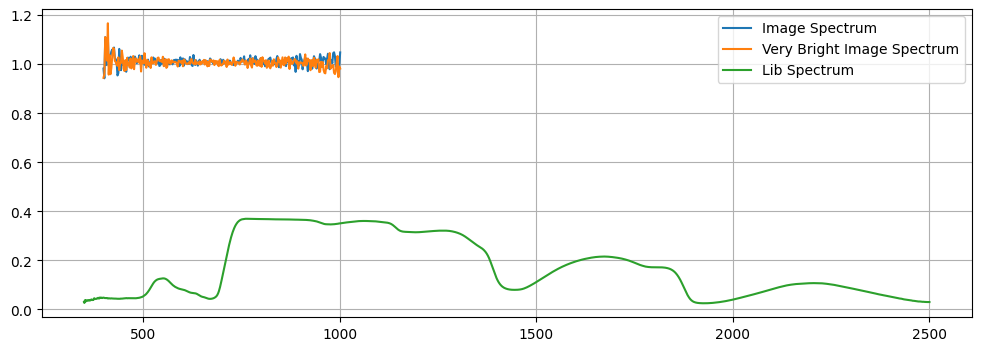

In [14]:
plt.figure(figsize=(12,4))
plt.plot(wl_im, im.Arr[100,100,:].flatten(), label='Image Spectrum')
plt.plot(wl_im, im.Arr[172,233,:].flatten(), label='Very Bright Image Spectrum')
plt.plot(wl_lib, spectra[5,:].flatten(), label='Lib Spectrum')
plt.grid()
plt.legend()

# Check wavelengths

In [15]:
print(f'Number of image wavelengths: {len(wl_im)}.')
print(f'Number of library wavelengths: {len(wl_lib)}.')
print('')
print(f'First 10 image wavelengths: {wl_im[:10]}.')
print('')
print(f'First 10 library wavelengths: {wl_lib[:10]}.')

Number of image wavelengths: 272.
Number of library wavelengths: 2151.

First 10 image wavelengths: [399.60645307 401.82729662 404.04814017 406.26898373 408.48982728
 410.71067083 412.93151438 415.15235793 417.37320148 419.59404503].

First 10 library wavelengths: [350. 351. 352. 353. 354. 355. 356. 357. 358. 359.].


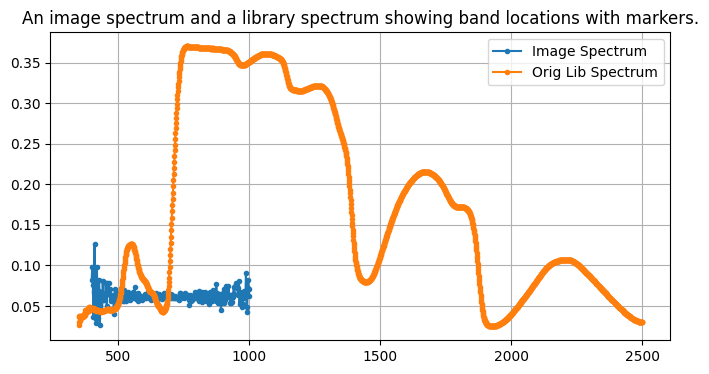

In [16]:
plt.figure(figsize=(8,4))
plt.title('An image spectrum and a library spectrum showing band locations with markers.')
plt.plot(wl_im, im.Arr[1000,500,:].flatten(), marker='.', label='Image Spectrum')
plt.plot(wl_lib, spectra[5,:].flatten(), marker='.', label='Orig Lib Spectrum')
plt.grid()
plt.legend()

### Resampling the library wavelength to match the image.

In [17]:
# Create a BandResampler, which is a function that resamples spectra from one source to match a different source.
# See: https://www.spectralpython.net/class_func_ref.html?highlight=resampling#spectral.algorithms.resampling.BandResampler
# Inputs: the first input is the wavelengths for the spectra that you are going to resample, the second input is the wavelevngths that you want to resample to.
resampler = spectral.BandResampler(wl_lib, wl_im)
spectra_resampled = resampler(spectra.T).T

print(f'The shape of the spectral library is {spectra_resampled.shape}.')
print(f'({spectra_resampled.shape[0]} spectra with {spectra_resampled.shape[1]} bands.)')

The shape of the spectral library is (277, 272).
(277 spectra with 272 bands.)


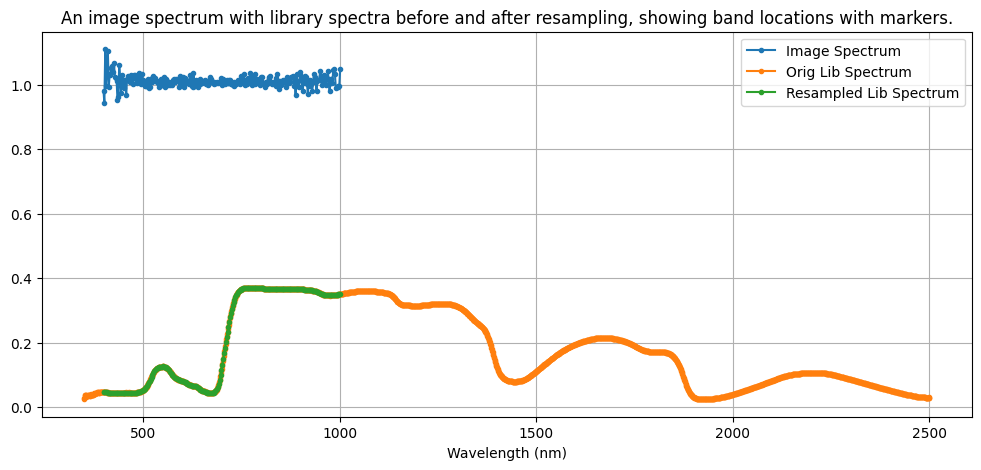

In [18]:
plt.figure(figsize=(12,5))
plt.title('An image spectrum with library spectra before and after resampling, showing band locations with markers.')
plt.plot(wl_im, im.Arr[100,100,:].flatten(), marker='.', label='Image Spectrum')
plt.plot(wl_lib, spectra[5,:].flatten(), marker='.', label='Orig Lib Spectrum')
plt.plot(wl_im, spectra_resampled[5,:].flatten(), marker='.', label='Resampled Lib Spectrum')
plt.xlabel('Wavelength (nm)')
plt.grid()
plt.legend();

In [19]:
# now that the library is resampled, let's use simple names.
spec = spectra_resampled # spectra from the library, after resampling
wl = wl_im # the wavelengths for the image and the resampled library

# Part 2: Initial Evaluation of Spectral Library

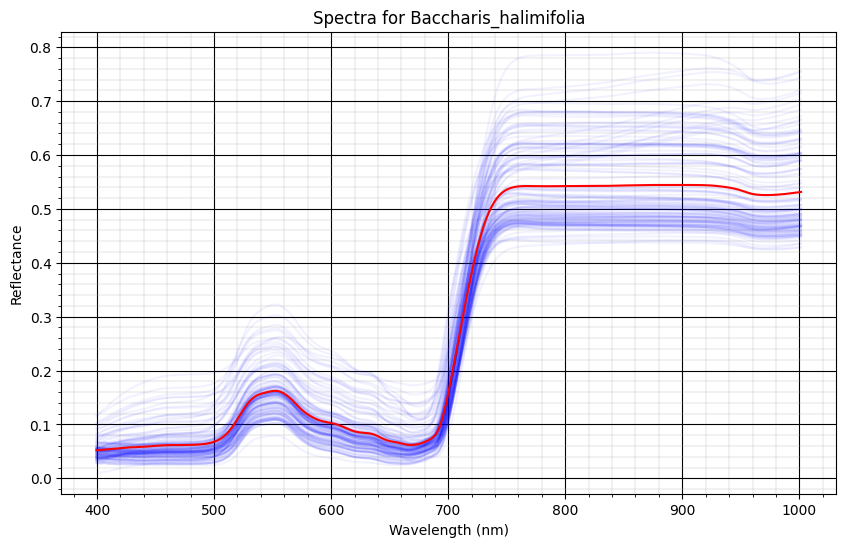

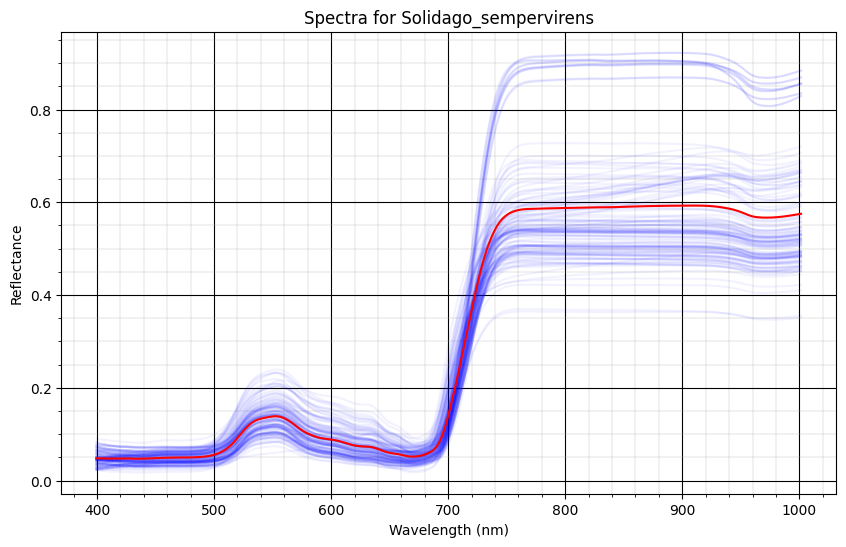

In [20]:
# plot the mean (red) and all individual spectra (blue) of each class
# we save the mean for each class for use later
means = {}
for name in names_unique:
    class_spectra = spec[spectra_names==name,:]
    class_nSpec = class_spectra.shape[0]
    plt.figure(figsize=(10,6)) 
    for i in range(class_nSpec):
        plt.plot(wl,class_spectra[i,:].flatten(), color='b', alpha=0.05)
    means[name] = np.mean(class_spectra, axis=0)
    plt.plot(wl, means[name], color='r')
    plt.minorticks_on()
    plt.grid(True, which='major', c='k')
    plt.grid(True, which='minor', linewidth=0.25)
    plt.title(f'Spectra for {name}')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.grid(True)

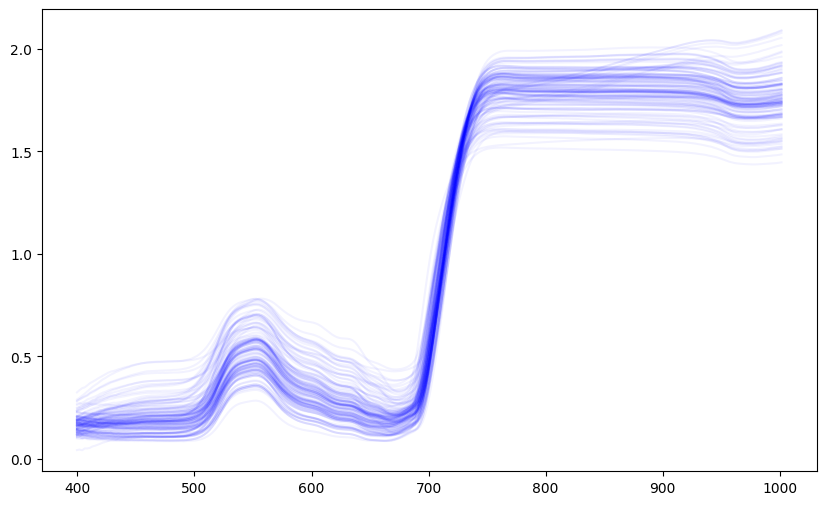

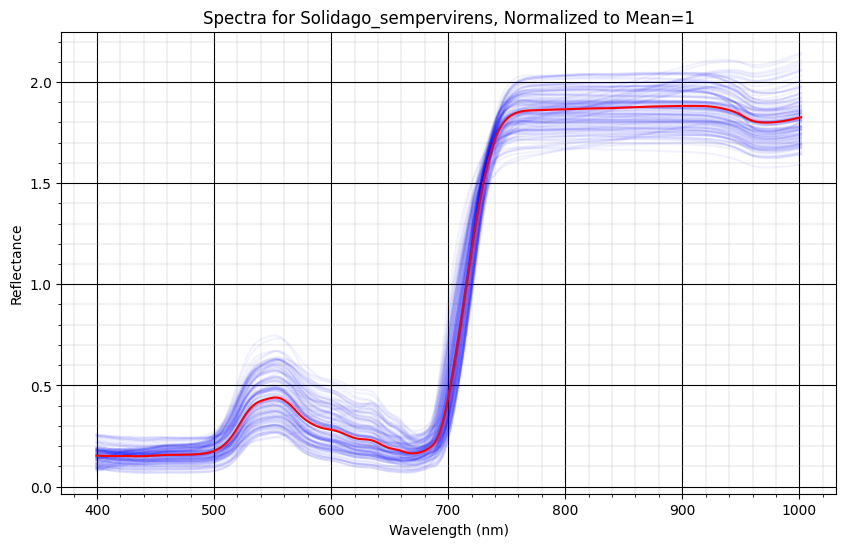

In [21]:
# plot the mean (red) and all individual spectra (blue) of each class, scaling all spectra to have mean value of 1
for name in names_unique:
    class_spectra = spec[spectra_names==name,:]
    class_nSpec = class_spectra.shape[0]
    plt.figure(figsize=(10,6)) 
    for i in range(class_nSpec):
        plt.plot(wl,class_spectra[i,:].flatten()/np.mean(class_spectra[i,:].flatten()), color='b', alpha=0.05)
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.plot(wl, means[name]/np.mean(means[name]), color='r')
plt.title(f'Spectra for {name}, Normalized to Mean=1')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid(True)

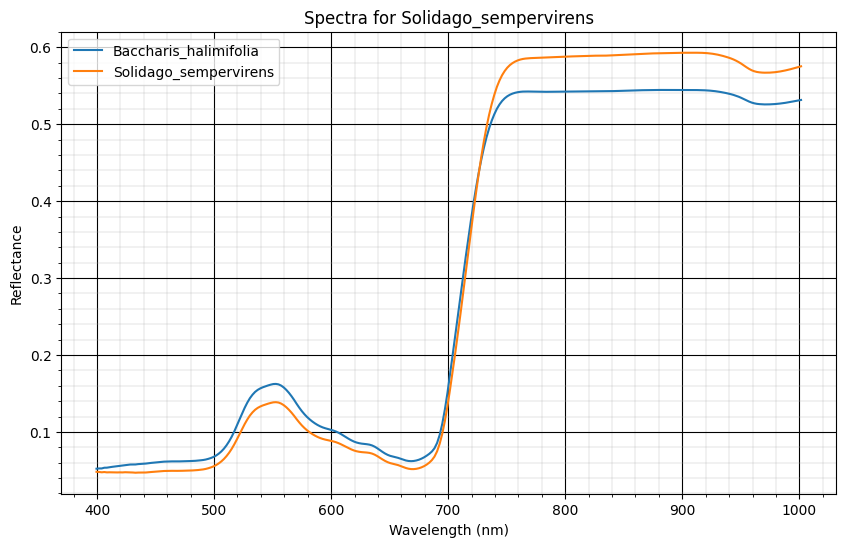

In [22]:
# plot all the means together
plt.figure(figsize=(10,6)) 
for name in names_unique:
    plt.plot(wl, means[name], label=name)
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title(f'Spectra for {name}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)

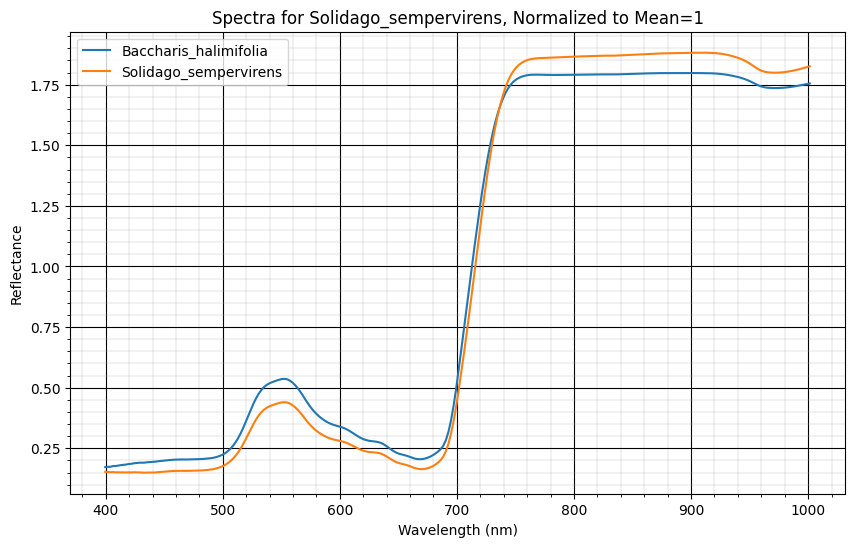

In [23]:
# plot all the means together
plt.figure(figsize=(10,6)) 
for name in names_unique:
    plt.plot(wl, means[name]/np.mean(means[name]), label=name)
plt.title(f'Spectra for {name}, Normalized to Mean=1')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)

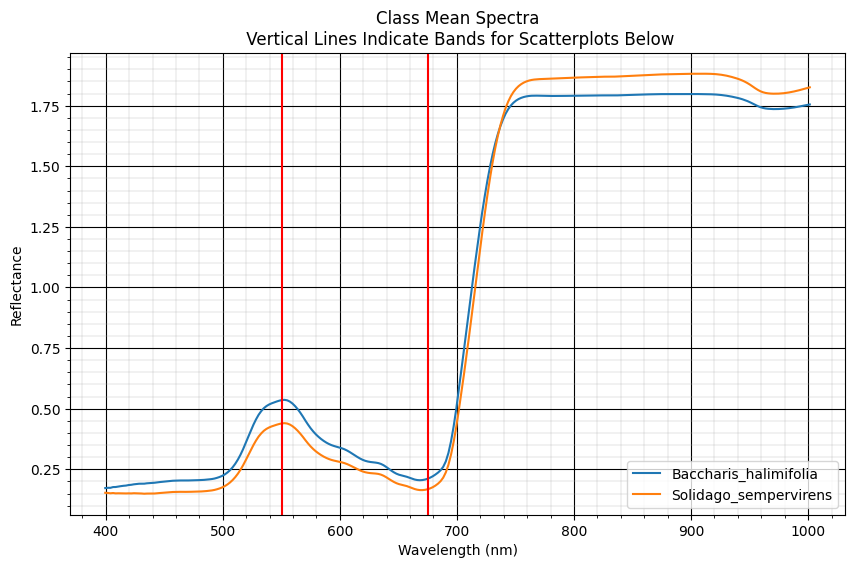

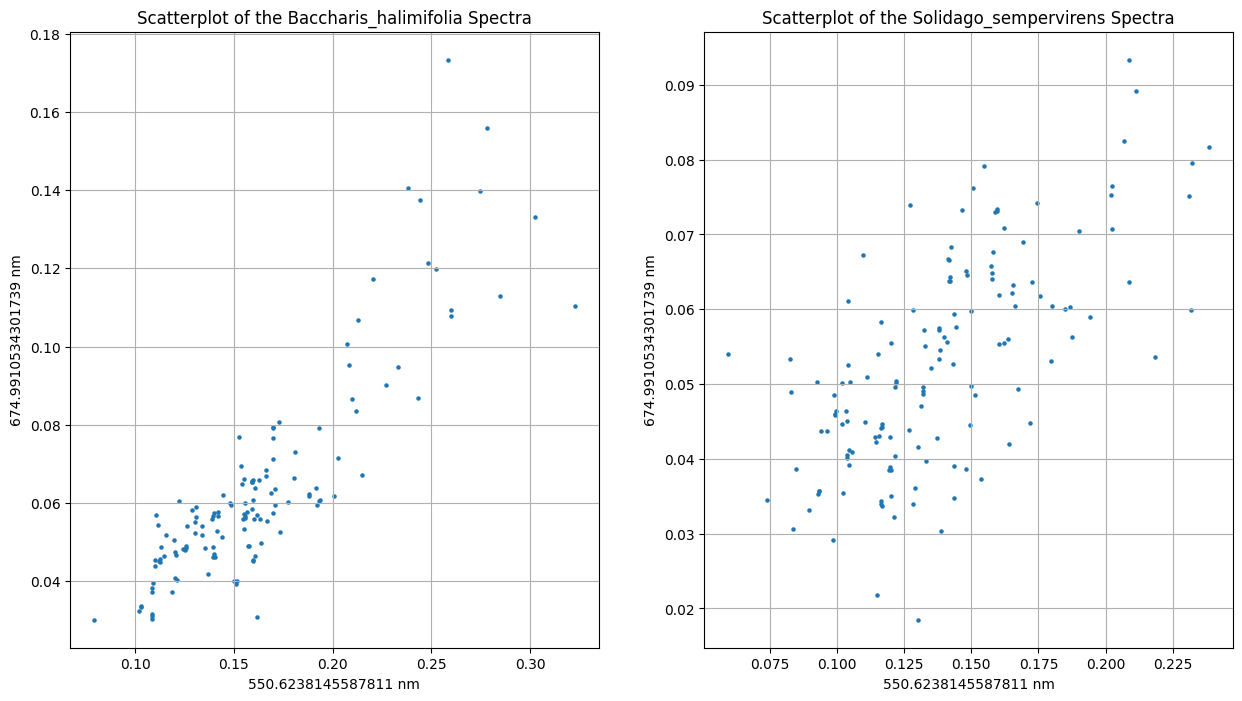

In [24]:
# Plot the class Means, then a scatterplot of each class on the same 2 bands
b1 = np.argmin(np.abs(wl-550))# index for band 1 for scatterplots
b2 = np.argmin(np.abs(wl-675))# index for band 2 for scatterplots

plt.figure(figsize=(10,6)) 
for name in names_unique:
    plt.plot(wl, means[name]/np.mean(means[name]), label=name)
plt.axvline(wl[b1], color='red')
plt.axvline(wl[b2], color='red')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.title(f'Class Mean Spectra\n Vertical Lines Indicate Bands for Scatterplots Below')
plt.legend()
plt.grid(True)

nPlotRows = int(np.ceil(len(names_unique)/2))
plt.figure(figsize=(15,int(8*nPlotRows)))
i = 0
for name in names_unique:
    plt.subplot(nPlotRows, 2, i+1)  
    plt.title(f'Scatterplot of the {name} Spectra')
    class_spectra = spec[spectra_names==name,:]
    plt.scatter(class_spectra[:,b1], class_spectra[:,b2], s=5)
    plt.xlabel(f'{wl[b1]} nm')
    plt.ylabel(f'{wl[b2]} nm')
    plt.grid(True);
    i = i + 1

# PART 4: Viewing scatterplots of the library spectra

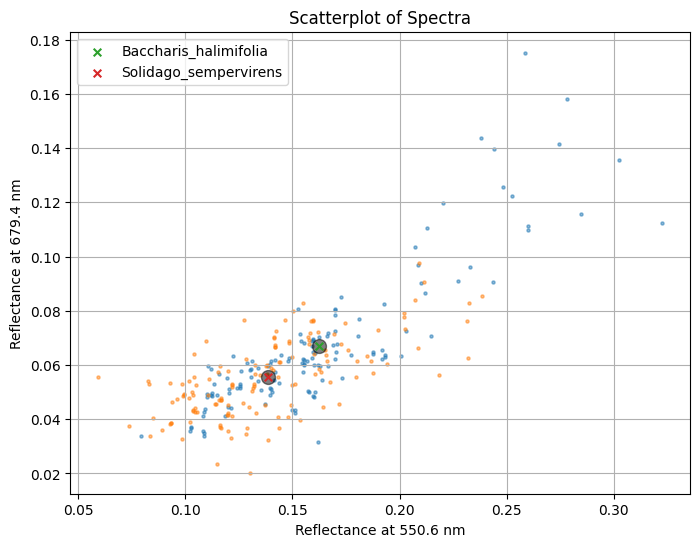

In [25]:
# Create a scatterplot of the data
i1 = np.argmin(np.abs(wl-550))
i2 =  np.argmin(np.abs(wl-680))

# sort by number of pixels in each ROI
# pixCount = []
# for name in names_unique:
#     pixCount.append(np.sum(roi_masks[name]))
# pixCount = np.asarray(pixCount)
# idx_order = np.argsort(-pixCount)

plt.figure(figsize=(8,6))

# plot all of the spectra for this class
for name in names_unique:
    # get the ROI name
    #name = names[i]
    # get the indices for the spectra for this class
    class_spectra = spec[spectra_names==name,:]    
    # scatterplot the class spectra at this band
    plt.scatter(class_spectra[:,i1], class_spectra[:,i2], s=5, alpha=0.5);
    
    
# plot the class mean spectrum for this class
for name in names_unique:
    # get the ROI name
    #name = names[i]
    # scatterplot the class mean spectrum at this band
    plt.scatter(means[name][i1], means[name][i2], s=100, color='k', alpha=0.5);
    plt.scatter(means[name][i1], means[name][i2], marker='x', s=30, label=name);
    
plt.grid(True)
plt.legend()
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of Spectra');

# PART 5: Viewing PCA-transformed scatterplots of the ROI spectra

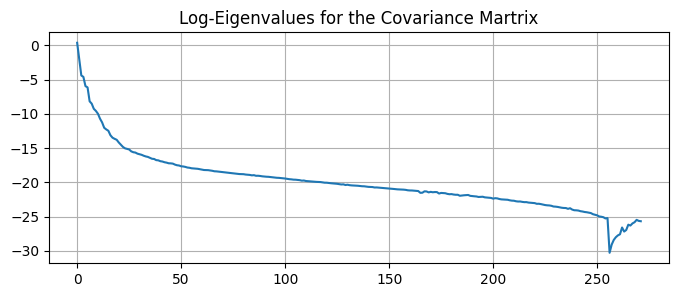

In [26]:
# compute mean and covariance of the spectra
mu = np.mean(spec, axis=0)
C = np.cov(spec.T)

# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# Plot the eigenvalues to examine stability 
# (Only the first N-1 of these will be meaningful, where N = # classes)
plt.figure(figsize=(8,3))
plt.plot(np.log(evals))
plt.grid(True)
plt.title('Log-Eigenvalues for the Covariance Martrix')
# truncate the small eigenvalues to stablize the inverse
tol = 10**(-6)
evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)

# whiten the spectra
Wspectra = np.matmul(W.T, (spec-mu).T).T

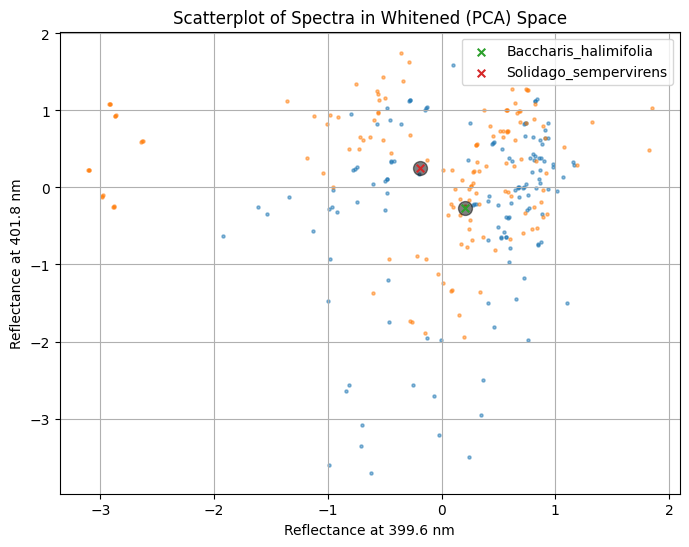

In [27]:
# Create a scatterplot of the data
i1 = 0
i2 = 1

# sort by number of pixels in each ROI
# pixCount = []
# for name in names:
#     pixCount.append(np.sum(roi_masks[name]))
# pixCount = np.asarray(pixCount)
# idx_order = np.argsort(-pixCount)

plt.figure(figsize=(8,6))

Wmeans = {}
# plot all of the spectra for this class
for name in names_unique:
    # get the ROI name
    #name = names[i]
    # get the indices for the spectra for this class
    class_spectra = Wspectra[spectra_names==name,:]   
    Wmeans[name] = np.mean(class_spectra, axis=0)
    # scatterplot the class spectra at this band
    plt.scatter(class_spectra[:,i1], class_spectra[:,i2], s=5, alpha=0.5);
    
    
# plot the class mean spectrum for this class
for name in names_unique:
    # get the ROI name
    #name = names[i]
    # scatterplot the class mean spectrum at this band
    plt.scatter(Wmeans[name][i1], Wmeans[name][i2], s=100, color='k', alpha=0.5);
    plt.scatter(Wmeans[name][i1], Wmeans[name][i2], marker='x', s=30, label=name);
    
plt.grid(True)
plt.legend()
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of Spectra in Whitened (PCA) Space');

### Observe that there is often overlap here between vegetation species, or more generally between similar classes.

# Part 6: Viewing LDA-transformed scatterplots of the ROI spectra

### on LDA from https://en.wikipedia.org/wiki/Linear_discriminant_analysis
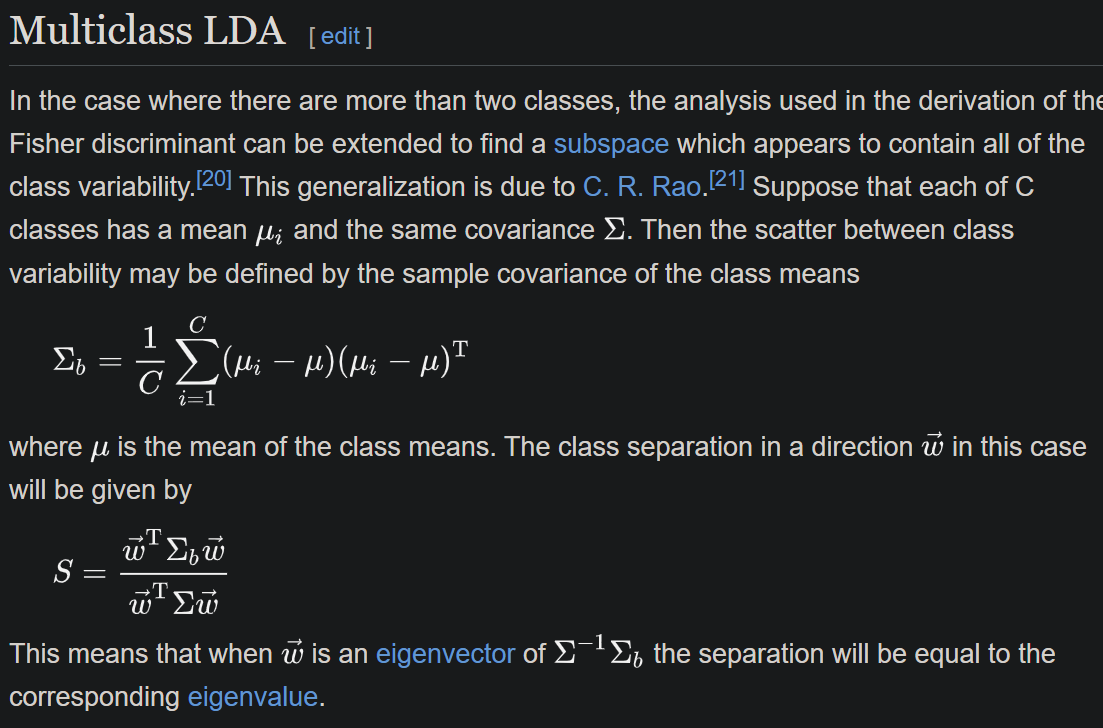

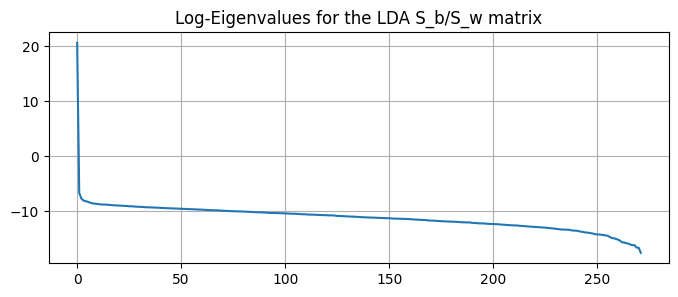

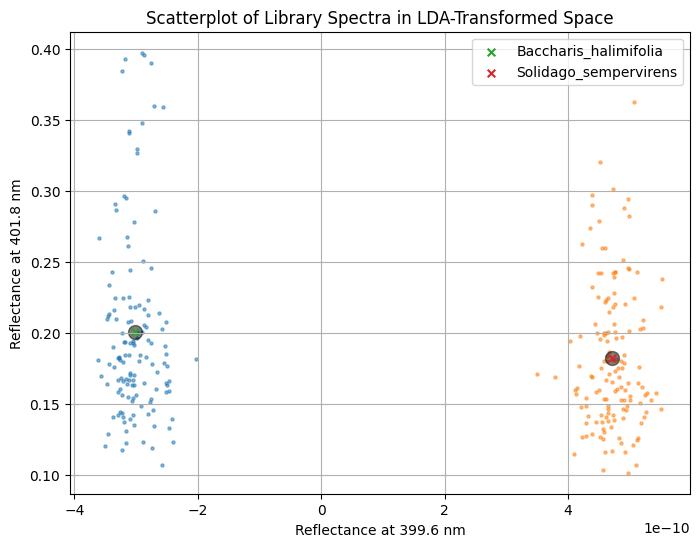

In [28]:
# ----- Compute the LDA Transform -----

# Compute the covaraince (often called the within-class-scatter in LDA, denoted S_W)
nClasses = len(names_unique)
nb = spec.shape[1]
nSpec = spec.shape[0]
C = np.zeros((nb,nb)) # covariance (Sigma in the Wikipedia page)
for name in names_unique:
    # get the spectra for this class
    class_spectra = spec[spectra_names==name,:]    
    # compute the covariance for this class
    C_class = np.cov(class_spectra.T)
    # compute the number of spectra in this class
    nSpec_class = class_spectra.shape[0]
    # add the covariance of this class,
    # weighted by the fraction of total pixels that come from this class
    C = C + (nSpec_class/nSpec)*C_class 
    
# Computing the coavariance of the means (often called the between-class scatter in LDA, denoted S_b)
Cb = np.zeros((nb,nb))
for name in names_unique:
    mu_diff = np.reshape((means[name] - mu), (nb,1))
    #Cb = Cb + (1/nClasses)*np.matmul(mu_diff, mu_diff.T) # <---- This formula is for balanced datasets
    nSpec_class = np.sum(spectra_names==name)
    Cb = Cb + (nSpec_class)*np.matmul(mu_diff, mu_diff.T) # <---- This formula is for imbalanced datasets

# Compute SVD of S_W^(-1) S_B
evecs, evals, Vt = np.linalg.svd(np.linalg.pinv(C).dot(Cb))
# Plot the eigenvalues to examine stability 
# (Only the first N-1 of these will be meaningful, where N = # classes)
plt.figure(figsize=(8,3))
plt.plot(np.log(evals))
plt.grid(True)
plt.title('Log-Eigenvalues for the LDA S_b/S_w matrix')
# truncate the small eigenvalues to stablize the inverse
tol = 10**(-6)
evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W_lda = np.matmul(evecs,DiagMatrix)

# LDA-transform the spectra
LDA_spectra = np.matmul(W_lda.T, (spec).T).T



# ----- Plot the Transformed Data -----
# Create a scatterplot of the data
i1 = 0
i2 = 1
# sort by number of pixels in each ROI
# pixCount = []
# for name in names_unique:
#     pixCount.append(np.sum(roi_masks[name]))
# pixCount = np.asarray(pixCount)
# idx_order = np.argsort(-pixCount)
# Create the scatterplot of the LDA-transformed data
plt.figure(figsize=(8,6))
LDA_means = {}
# plot all of the spectra for this class
for name in names_unique:
    # get the ROI name
    #name = names[i]
    # get the indices for the spectra for this class
    class_spectra = LDA_spectra[spectra_names==name,:]   
    LDA_means[name] = np.mean(class_spectra, axis=0)
    # scatterplot the class spectra at this band
    plt.scatter(class_spectra[:,i1], class_spectra[:,i2], s=5, alpha=0.5);
# plot the class mean spectrum for this class
for name in names_unique:
    # get the ROI name
    #name = names[i]
    # scatterplot the class mean spectrum at this band
    plt.scatter(LDA_means[name][i1], LDA_means[name][i2], s=100, color='k', alpha=0.5);
    plt.scatter(LDA_means[name][i1], LDA_means[name][i2], marker='x', s=30, label=name);
plt.grid(True)
plt.legend()
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of Library Spectra in LDA-Transformed Space');

# Part 7: Computing Mahalanobis Distances

In [29]:
nClasses = len(names_unique)
nb = spec.shape[1]
C = np.zeros((nb,nb)) # covariance (Sigma in the Wikipedia page)
for name in names_unique:
    # get the spectra for this class
    class_spectra = spec[spectra_names==name,:]    
    # compute the covariance for this class
    C_class = np.cov(class_spectra.T)
    # compute the number of spectra in this class
    nSpec_class = class_spectra.shape[0]
    # add the covariance of this class,
    # weighted by the fraction of total pixels that come from this class
    C = C + (nSpec_class/nSpec)*C_class 

# compute the whitening matrix
evals,evecs = np.linalg.eig(C)
tol = 10**(-6)
evals[evals<tol] = tol
#DiagMatrix = np.diag(evals**(-1/2))
#roi_Ws[name] = np.matmul(evecs,DiagMatrix)
DiagMatrix = np.diag(evals**(-1/2))
W_all = np.matmul(evecs,DiagMatrix)
    
# Create array to hold the Mahalanobis Distance
MD = np.zeros((nSpec, nClasses))

# compute the mean and covariance for each class
#roi_means = {}
#roi_Ws = {}
i = 0
for name in names_unique:
    # get the spectra for this class
    class_spectra = spec[spectra_names==name,:] 
    # compute the covariance for this class
    mu = np.mean(class_spectra, axis=0)
    C = np.cov(class_spectra.T)
    # Compute the eigenvectors, eigenvalues, and whitening matrix
    evals,evecs = np.linalg.eig(C)
    # truncate the small eigenvalues to stablize the inverse
    tol = 10**(-6)
    evals[evals<tol] = tol
    #DiagMatrix = np.diag(evals**(-1/2))
    #roi_Ws[name] = np.matmul(evecs,DiagMatrix)
    DiagMatrix = np.diag(evals**(-1/2))
    W_this_class = np.matmul(evecs,DiagMatrix)
    
    if np.sum(spectra_names==name) < 100:
        W = W_all
    else:
        W = W_this_class        
    
    MD_class = np.sqrt(np.sum((np.matmul(W.T, (spec-mu).T).T)**2, axis=1))
    MD[:,i] = MD_class
    i = i + 1

/tmp/ipykernel_7108/1985853931.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  MD[:,i] = MD_class


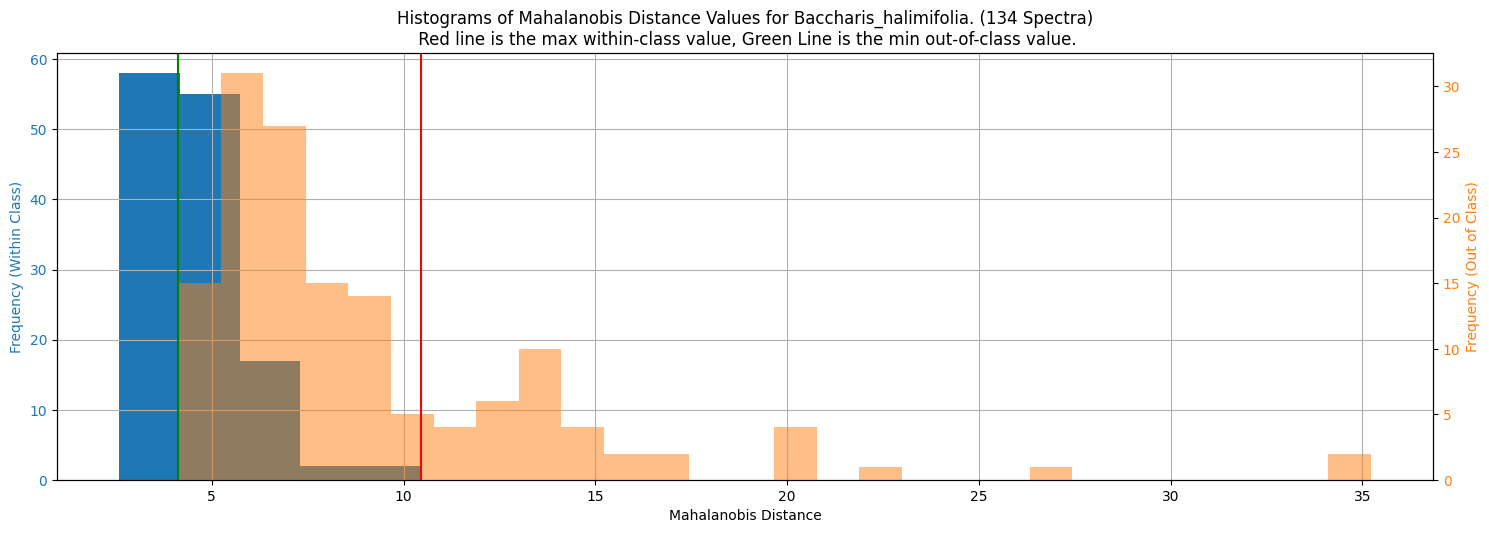

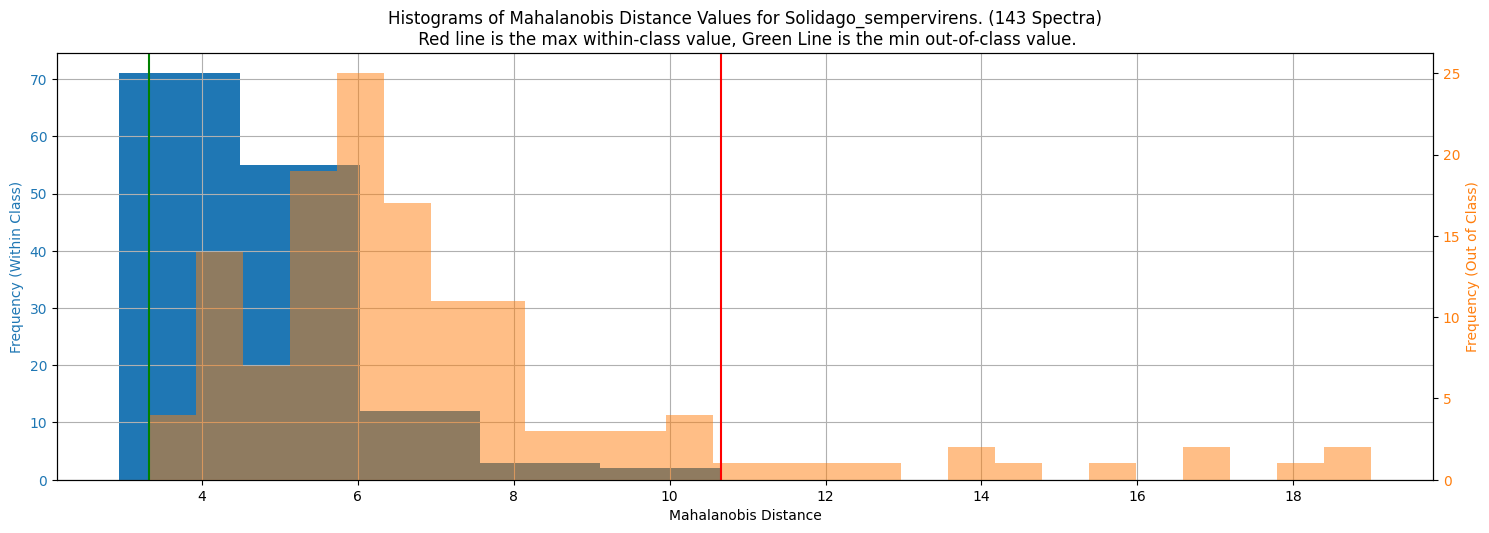

In [30]:
# Plot within-class and out-of-class histograms, giving each their own axis
for classIndex in range(nClasses):
    fig, ax1 = plt.subplots(figsize=(15,5))

    name = names_unique[classIndex]
    MD_this_class = MD[:,classIndex]
    MD_within_class = MD_this_class[spectra_names==name]
    MD_other_classes = MD_this_class[spectra_names!=name]
    MD_other_classes = np.clip(MD_other_classes, a_min=0, a_max=np.percentile(MD_other_classes, 99))  
    nSpectra_thei_class = np.sum(spectra_names==name)

    color = 'tab:blue'
    ax1.set_xlabel('Mahalanobis Distance')
    ax1.set_ylabel('Frequency (Within Class)', color=color)    
    bins = min(5, len(MD_within_class) // 10)
    if bins<5: 
        bins=5
    ax1.hist(MD_within_class, bins=bins);
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    
    color = 'tab:orange'
    ax2.set_ylabel('Frequency (Out of Class)', color=color)  # we already handled the x-label with ax1  
    bins = min(50, len(MD_other_classes) // 5)
    ax2.hist(MD_other_classes, bins=bins, color=color, alpha=0.5);
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.axvline(np.max(MD_within_class), color='r')    
    plt.axvline(np.min(MD_other_classes), color='g')

    ax1.grid(True)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'Histograms of Mahalanobis Distance Values for {name}. ({nSpectra_thei_class} Spectra)\n Red line is the max within-class value, Green Line is the min out-of-class value.');
    plt.show()

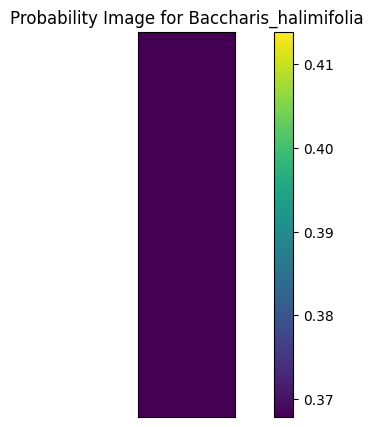

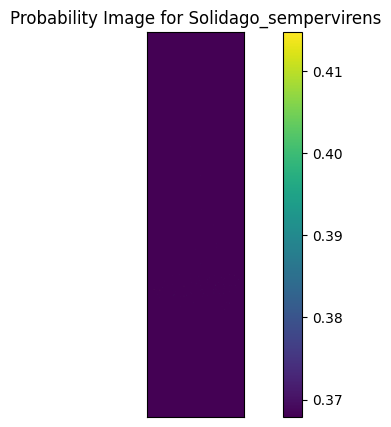

In [31]:
nClasses = len(names_unique)
nb = spec.shape[1]
C = np.zeros((nb,nb)) # covariance (Sigma in the Wikipedia page)
for name in names_unique:
    # get the spectra for this class
    class_spectra = spec[spectra_names==name,:]    
    # compute the covariance for this class
    C_class = np.cov(class_spectra.T)
    # compute the number of spectra in this class
    nSpec_class = class_spectra.shape[0]
    # add the covariance of this class,
    # weighted by the fraction of total pixels that come from this class
    C = C + (nSpec_class/nSpec)*C_class 

# compute the whitening matrix
evals,evecs = np.linalg.eig(C)
tol = 10**(-6)
evals[evals<tol] = tol
#DiagMatrix = np.diag(evals**(-1/2))
#roi_Ws[name] = np.matmul(evecs,DiagMatrix)
DiagMatrix = np.diag(evals**(-1/2))
W_all = np.matmul(evecs,DiagMatrix)
    
# Create array to hold the Mahalanobis Distance
MD = np.zeros((nSpec, nClasses))

# compute the mean and covariance for each class
#roi_means = {}
#roi_Ws = {}
for name in names_unique:
    plt.figure(figsize=(10,5))
    # get the spectra for this class
    class_spectra = spec[spectra_names==name,:] 
    # compute the covariance for this class
    mu = np.mean(class_spectra, axis=0)
    C = np.cov(class_spectra.T)
    # Compute the eigenvectors, eigenvalues, and whitening matrix
    evals,evecs = np.linalg.eig(C)
    # truncate the small eigenvalues to stablize the inverse
    tol = 10**(-6)
    evals[evals<tol] = tol
    #DiagMatrix = np.diag(evals**(-1/2))
    #roi_Ws[name] = np.matmul(evecs,DiagMatrix)
    DiagMatrix = np.diag(evals**(-1/2))
    W_this_class = np.matmul(evecs,DiagMatrix)
    
    if np.sum(spectra_names==name) < 100:
        W = W_all
    else:
        W = W_this_class        
    
    MD_class = np.sqrt(np.sum((np.matmul(W_all.T, (im.List-mu).T).T)**2, axis=1)) #use W_all
    MD_class[MD_class>100] = 100
    MD_class = MD_class/np.mean(MD_class) # 
    MD_class = np.real(MD_class)
    #MD_class = MD_class - np.min(MD_class)
    MD_class_im = np.reshape(MD_class, (nr,nc))
    plt.imshow(np.exp(-MD_class_im))
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Probability Image for {name}')
    plt.colorbar()

# WORK-IN-PROGRESS Evaluation Metrics

In [ ]:
# See: https://scikit-learn.org/1.5/api/sklearn.metrics.html


In [ ]:
from sklearn.metrics import classification_report

y_true = gt_list[np.where(gt_list>0)[0]]
LDA_class_list = np.argmin(MD_all, axis=1)
y_pred = LDA_class_list[np.where(gt_list>0)[0]]


# modifying for scoring
y_true = y_true - 1
y_true = (y_true).astype(int)

cr = classification_report(y_true, y_pred, target_names=class_names)

print(cr)

In [ ]:
MD_all[2000,:]**(-1)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# get a predicted score value (higher value => more likely to be in the class)
y_pred_scores = MD_all[np.where(gt_list>0)[0],:]**(-1)
y_true = gt_list[np.where(gt_list>0)[0]]

plt.figure(figsize=(15,int(8*nPlotRows)))
for i in range(nClasses):
    plt.subplot(nPlotRows, 2, i+1) 
    
    y_true_this_class = (y_true==(i+1))
    y_pred_scores_this_class = y_pred_scores[:,i]
    
    fpr, tpr, thresholds = roc_curve(y_true_this_class, y_pred_scores_this_class)
    auc = roc_auc_score(y_true_this_class, y_pred_scores_this_class)
    
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'ROC Curve for {class_names[i]}, ACU={auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)